In [1]:
import os
import time

# Data processing tools
import pandas as pd
import numpy as np
# NLP tools
import nltk
import morfeusz2
from sklearn.feature_extraction.text import TfidfVectorizer
# Clustering and evaluation tools
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
# Visualisation tools
import matplotlib.pyplot as plt
import matplotlib.cm as cm


local_path = '/home/milosh-dr/code/MPs'

df = pd.read_csv(os.path.join(local_path, 'transformed_results.csv'))

votes_info = pd.read_csv('votes_info.csv')

In [2]:
df.head()

,Party,MPS,62/1,62/2,62/3,62/4,62/5,62/6,62/7,62/8,...,46/57,46/58,46/59,46/60,46/61,46/62,46/63,46/64,46/65,46/66
0,PiS,Adamczyk Andrzej,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
1,PiS,Andruszkiewicz Adam,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
2,PiS,Andzel Waldemar,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
3,PiS,Ardanowski Jan Krzysztof,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
4,PiS,Arent Iwona,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0


In [3]:
votes_info.head()

,session_no,session_url,date,vote_no,vote_url,vote_time,vote_topic,vote_type
0,62,https://www.sejm.gov.pl/sejm9.nsf/agent.xsp?sy...,28 września 2022 r.,1,https://www.sejm.gov.pl/sejm9.nsf/agent.xsp?sy...,12:39:39,Pkt. 3 Sprawozdanie Komisji o uchwale Senatu w...,poprawki nr 1-7 i 9
1,62,https://www.sejm.gov.pl/sejm9.nsf/agent.xsp?sy...,28 września 2022 r.,2,https://www.sejm.gov.pl/sejm9.nsf/agent.xsp?sy...,12:40:10,Pkt. 3 Sprawozdanie Komisji o uchwale Senatu w...,poprawka 8
2,62,https://www.sejm.gov.pl/sejm9.nsf/agent.xsp?sy...,28 września 2022 r.,3,https://www.sejm.gov.pl/sejm9.nsf/agent.xsp?sy...,12:40:33,Pkt. 3 Sprawozdanie Komisji o uchwale Senatu w...,poprawki nr 10-11
3,62,https://www.sejm.gov.pl/sejm9.nsf/agent.xsp?sy...,28 września 2022 r.,4,https://www.sejm.gov.pl/sejm9.nsf/agent.xsp?sy...,12:41:31,Pkt. 2 Pierwsze czytanie poselskiego projektu ...,wniosek o odrzucenie projektu w pierwszym czyt...
4,62,https://www.sejm.gov.pl/sejm9.nsf/agent.xsp?sy...,28 września 2022 r.,5,https://www.sejm.gov.pl/sejm9.nsf/agent.xsp?sy...,12:42:25,62. posiedzenie Sejmu Rzeczypospolitej Polskie...,wniosek o zastosowanie art. 39 ust. 3 regulami...


***Opisz tutaj jakie masz dane itd***

### Cleaning votes_info

**votes_info** needs to be cleaned up. Let's restore *vote_id* column to match the format we use in **df**

In [4]:
votes_info['vote_id'] = votes_info['session_no'].astype('str') + '/' + votes_info['vote_no'].astype('str')

Next we'll convert date and time to *pd.datetime* format

In [5]:

# Create mapping for months
mapping = {
    'stycz\w+':'01',
    'lut\w+':'02',
    'mar\w+':'03',
    'kwie\w+':'04',
    'maj\w+':'05',
    'czerw\w+':'06',
    'lip\w+':'07',
    'sierp\w+':'08',
    'wrze\w+':'09',
    'paździer\w+':'10',
    'listop\w+':'11',
    'grud\w+':'12'
}

# Replace months with their numeric representations
for verbose, numeric in mapping.items():
    votes_info['date'] = votes_info['date'].str.replace(f'(\d\d?)\s?({verbose})\s?(\d\d\d\d)\s?r\.', f'\\1-{numeric}-\\3', regex=True)

# Convert the information from 'date' and 'vote_time' columns into datetime format 'YYYY-MM-DD HH:MM:SS'
votes_info['time'] = pd.to_datetime(votes_info['date'] + ' ' + votes_info['vote_time'], format='%d-%m-%Y %H:%M:%S')

# Get rid of columns, that won't be used any more
votes_info.drop(['session_no', 'vote_no', 'date', 'vote_time', 'session_url', 'vote_url'], axis=1, inplace=True)

votes_info.head()

,vote_topic,vote_type,vote_id,time
0,Pkt. 3 Sprawozdanie Komisji o uchwale Senatu w...,poprawki nr 1-7 i 9,62/1,2022-09-28 12:39:39
1,Pkt. 3 Sprawozdanie Komisji o uchwale Senatu w...,poprawka 8,62/2,2022-09-28 12:40:10
2,Pkt. 3 Sprawozdanie Komisji o uchwale Senatu w...,poprawki nr 10-11,62/3,2022-09-28 12:40:33
3,Pkt. 2 Pierwsze czytanie poselskiego projektu ...,wniosek o odrzucenie projektu w pierwszym czyt...,62/4,2022-09-28 12:41:31
4,62. posiedzenie Sejmu Rzeczypospolitej Polskie...,wniosek o zastosowanie art. 39 ust. 3 regulami...,62/5,2022-09-28 12:42:25


## Dimensionality reduction

Our feature vectors have above 1700 dimensions. Let's explore what we could do to reduce this number.

A brief look into the vote_type column makes it clear that we can easily group votes into several major categories.

In [9]:
mapping = {
    'odrzuce': 'odrzucenie',
    'poprawk': 'poprawki',
    'głosowanie nad całością': 'głosowanie za',
    'mniejszości': 'wniosek mniejszości',
    'odpowiedzialności karnej': 'odpowiedzialność karna',
    'inne': 'inne'
}
votes_info['vote_category'] = (votes_info.vote_type
     .str.extract('(odrzuce|poprawk|głosowanie nad całością|mniejszości|odpowiedzialności karnej)', expand=False)
     .fillna('inne')
     .map(mapping))

votes_info['vote_category'].value_counts()

poprawki                  1220
głosowanie za              173
inne                       169
wniosek mniejszości         85
odrzucenie                  61
odpowiedzialność karna       6
Name: vote_category, dtype: int64

The majority of votings relate to amendments, with only around 230 being for or against the entire project. To get a clearer picture of MPs' preferences, we should focus on these vote IDs. This will help us distill our dataframe and reduce noise in the data.

In [10]:
# Create a list of selected categories
selection = ['głosowanie za', 'odrzucenie', 'odpowiedzialność karna']
# Select only those votings that have their category included in our selection
selected_votes = votes_info[votes_info['vote_category'].isin(selection)]
vote_ids = selected_votes['vote_id'].tolist()
# Create a list of columns for our new dataframe
new_cols = ['MPS', 'Party']
new_cols.extend(vote_ids)

df_short = df[new_cols]
df_short

In [13]:
# Uncomment when ready

# df_short.to_csv('transformed_results_short.csv', index=False)

## Clustering

Let's start with KMeans and try to figure out the number of clusters that best describe given data. We look within a range of 3-11. This way we can make some initial conclusions about alliances in the parliament. We end with k set to 11 which is the number of political parties in the parliament (including "niez." which describe unaffiliated members of parliament).

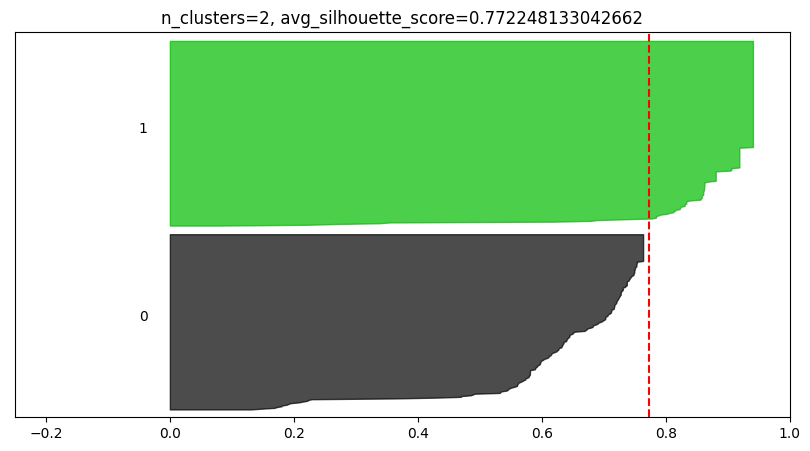

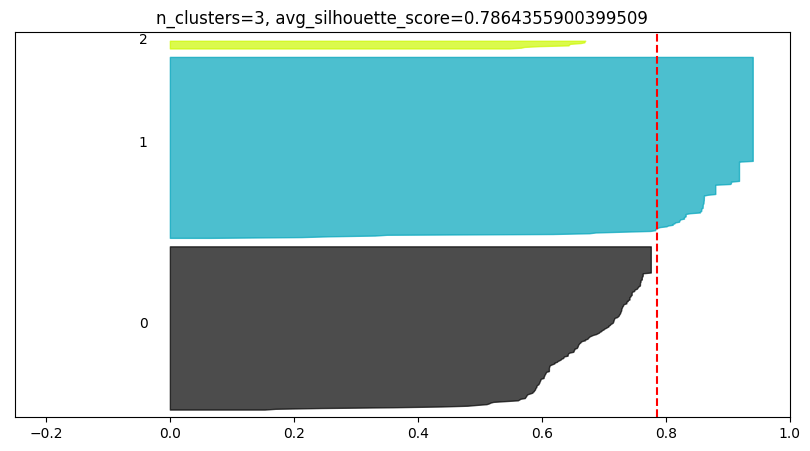

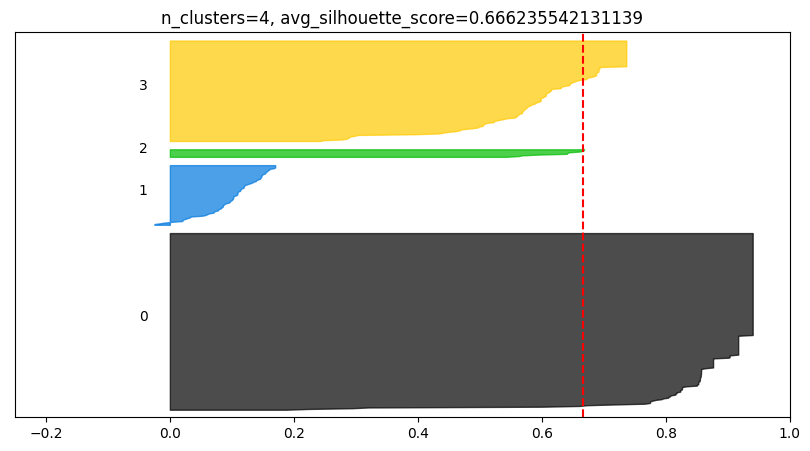

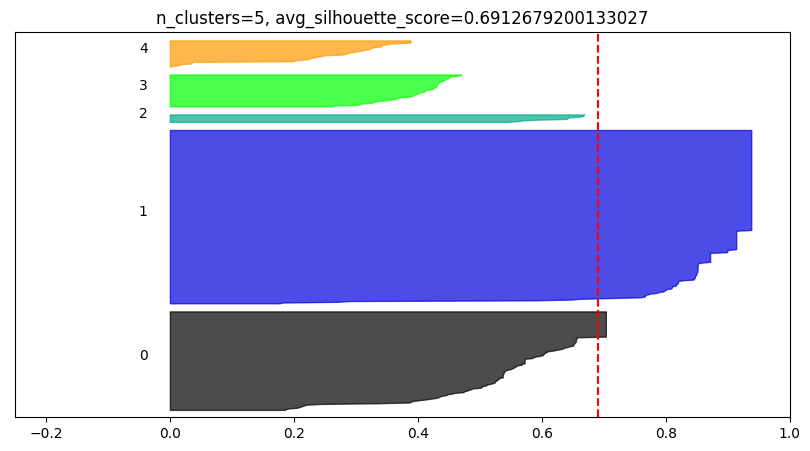

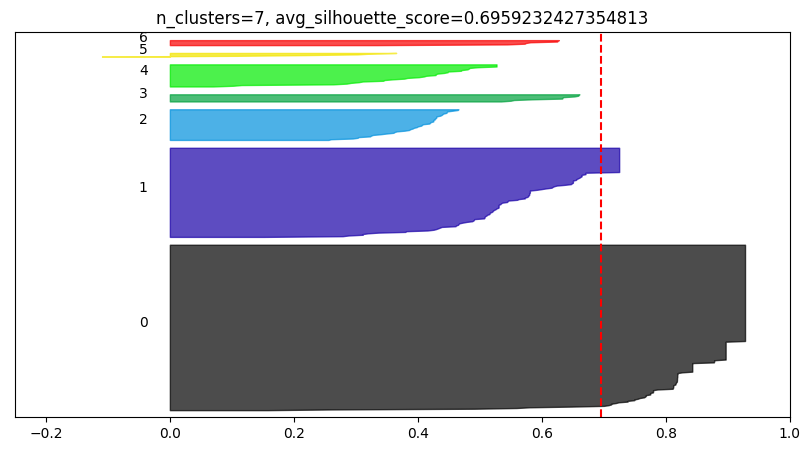

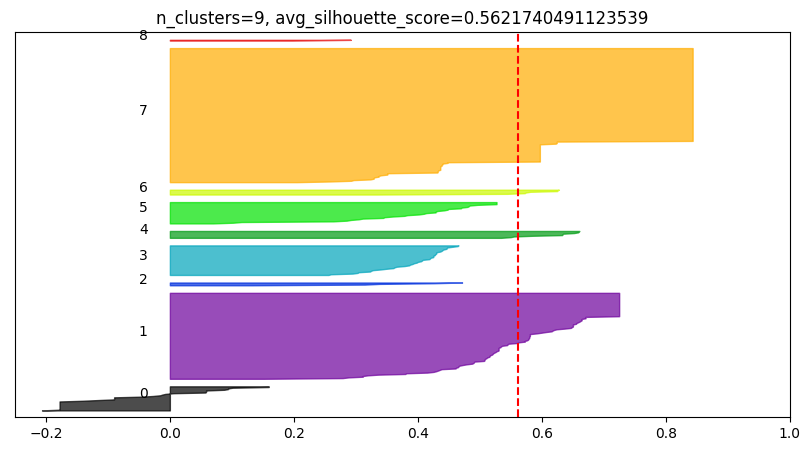

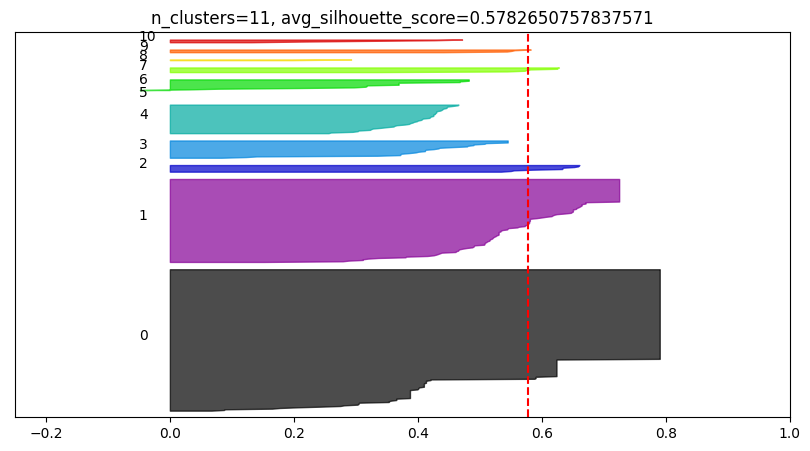

In [12]:
# Possibly get rid of party names' marking (commented part)

# Clustering data variable ??????


clustering_data=[df_short[['MPS', 'Party']]]
for n_clusters in [2,3,4,5,7,9,11]:
    ### This is new:
    clustering_data=[df_short[['MPS', 'Party']]]
    
    plt.figure(figsize=(10,5))
    plt.xlim([-.25,1])
    plt.ylim([0, df_short.shape[0] + (n_clusters + 1) * 10])
    ###
    model = KMeans(n_clusters=n_clusters, n_init=50, random_state=10)
    labels = pd.Series(model.fit_predict(df_short.iloc[:,2:]), name='clusters_{}_{}'.format(model.__class__.__name__, n_clusters))
    clustering_data.append(labels)
    ### This is new:
    
    clusters = pd.concat(clustering_data, axis=1)
    details = clusters.groupby('clusters_{}_{}'.format(model.__class__.__name__, n_clusters)).apply(lambda x: x['Party'].value_counts())
    
    silhouette_avg = silhouette_score(df_short.iloc[:,2:], labels)
    silhouette_values_samples = silhouette_samples(df_short.iloc[:,2:], labels)
    
    y_lower = 10
    for cluster in range(n_clusters):
        cluster_silhouette_values = silhouette_values_samples[labels == cluster]
        cluster_silhouette_values.sort()
        cluster_size = cluster_silhouette_values.shape[0]
        y_upper = y_lower + cluster_size
    
        color = cm.nipy_spectral(float(cluster) / n_clusters)
        plt.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        
        plt.text(-0.05, y_lower + 0.5 * cluster_size, str(cluster))
        distance = 20
        # for party in details[cluster].items():
        #     plt.text(0.05, y_upper - distance, str(party[0]) + ' - ' + str(party[1]))
        #     distance += 20
        y_lower = y_upper + 10
        
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.title('n_clusters={}, avg_silhouette_score={}'.format(n_clusters, silhouette_avg))
    plt.yticks([])
    ###
    
# clusters = pd.concat(clustering_data, axis=1)

# cols = [x for x in clusters.columns if x.startswith('clusters')]
# for col in cols:
#     display(clusters.groupby(col).apply(lambda x: x['Party'].value_counts()))

Suprisingly best defined clusters we got with n_clusters=3. Having more clusters resulted in significantly lower silhoutte scores. 
Investigating the cluster formed by most of oposition parties could help us define strategy for future collaboration between those parties.

In [13]:
model = KMeans(n_clusters=3, n_init=50, random_state=10)
clusters = pd.Series(model.fit_predict(df_short.iloc[:,2:]), name='cluster')
clustering_3 = pd.concat([df_short[['MPS', 'Party']], clusters], axis=1)

clustering_3.groupby('cluster').value_counts(['Party'])

cluster  Party       
0        KO              126
         Lewica           44
         KP               24
         Polska2050        8
         Porozumienie      5
         PPS               3
         PS                2
         niez.             1
1        PiS             228
         Kukiz15           4
         niez.             3
         PS                1
2        Konfederacja     11
dtype: int64

### Topic modelling

In [14]:
oposition_mask = clustering_3[clustering_3['cluster']==0].index

# Sprawdźmy, w których głosowaniach partie opozycyjne mówią jednym głosem (min 90% posłów głosuje jednomyślnie)

oposition_votes = df_short.iloc[oposition_mask, 2:]

unity = oposition_votes.apply(lambda x: x.value_counts(), axis=0).apply(lambda x: x.max()/x.sum()>.9, axis=0)
unity_ind = unity[unity==True].index
len(unity_ind)

198

In [15]:

# A teraz sprawdźmy, w których głosowaniach cały parlament mówi jednym głosem (min 90% posłów głosuje jednomyślnie)

total_votes = df_short.iloc[:, 2:]

total_unity = total_votes.apply(lambda x: x.value_counts(), axis=0).apply(lambda x: x.max()/x.sum()>.9, axis=0)
total_unity_ind = total_unity[total_unity==True].index
len(total_unity_ind)

134

W 198 głosowaniach (z 240 branych pod uwagę) opozycja (w rozumieniu wszystko poza PIS i Konfederacją) była jednomyślna.
Trzeba jednak wziąć pod uwagę, że z tego aż w 132 głosowaniach jednomyślny był cały parlament. Możemy przyjąć, że pozostałe 66 w jakiś sposób wiąże partie opozycyjne światopoglądowo.
Sprawdźmy tematykę tych głosowań. 

In [16]:
mask = ~unity_ind.isin(total_unity_ind)

topics = votes_info.loc[votes_info['vote_id'].isin(unity_ind[mask]), 'vote_topic']
for topic in topics[:20]:
    print(topic)

Pkt. 2 Pierwsze czytanie poselskiego projektu ustawy o przedłużeniu kadencji organów jednostek samorządu terytorialnego do dnia 30 kwietnia 2024 r. oraz o zmianie ustawy - Kodeks wyborczy (druk nr 2612) - wniosek o odrzucenie projektu w pierwszym czytaniu.
Pkt. 7 Sprawozdanie Komisji o pilnym rządowym projekcie ustawy o zasadach realizacji programów wsparcia przedsiębiorców w związku z sytuacją na rynku energii w latach 2022-2024 (druki nr 2616, 2621 i 2621-A) - głosowanie nad całością projektu.
Pkt. 10 Sprawozdanie Komisji o poselskim projekcie ustawy o przedłużeniu kadencji organów jednostek samorządu terytorialnego do dnia 30 kwietnia 2024 r. oraz o zmianie ustawy - Kodeks wyborczy (druki nr 2612 i 2635) - wniosek o odrzucenie w całości projektu.
Pkt. 10 Sprawozdanie Komisji o poselskim projekcie ustawy o przedłużeniu kadencji organów jednostek samorządu terytorialnego do dnia 30 kwietnia 2024 r. oraz o zmianie ustawy - Kodeks wyborczy (druki nr 2612 i 2635) - głosowanie nad całości

Raczej już usuń komentarze zbędne

In [17]:


def custom_tokenizer(document):
    # Get tokens with at least three letters, exclude digits 
    tokenizer = nltk.tokenize.RegexpTokenizer(r'(?u)\b[^\W\d]{3,}\b')
    tokens = tokenizer.tokenize(document)

    morf = morfeusz2.Morfeusz()
    # Get base form of each word and remove SGJP tag
    tokens = [morf.analyse(token)[0][2][1].split(':')[0] for token in tokens]

    return tokens

stop_words=['pierwszy', 'pierwsze', 'czytanie']

start = time.time()
tfidf = TfidfVectorizer(tokenizer=custom_tokenizer, stop_words=stop_words, max_df=.2).fit(topics)
end = time.time()

print('Fitting time: ', end-start)

start = time.time()
transformed_topics = tfidf.transform(topics)
end = time.time()

print('Transformation time: ', end-start)

/home/milosh-dr/code/MPs/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Fitting time:  10.1185781955719
Transformation time:  12.772649765014648


In [18]:
tfidf.stop_words_

{'całość',
 'czytać',
 'druk',
 'głosować',
 'inny',
 'komisja',
 'nad',
 'niektóry',
 'odrzucić',
 'oraz',
 'pkt',
 'poselski',
 'projekt',
 'rządowy',
 'sprawa',
 'sprawozdanie',
 'uchwała',
 'ustawa',
 'ustawić',
 'wniosek',
 'zmiana'}

In [19]:
names = tfidf.get_feature_names_out()
# Get most important features for each topic
for i, row in enumerate(transformed_topics.toarray()):
    
    non_zeros = row[row.nonzero()]

    # Get mean of non-zero values
    mean = np.mean(row[row.nonzero()])
    # Get indices where value is higher than the mean
    ind = np.where(row>mean)
    # Create a mask of sorted indices, where value is higher than the mean
    mask = [x for x in row.argsort()[::-1] if x in ind[0]]
    
    # Print original topics and labels
    print(topics.iloc[i])

    if ind[0].any():
        print(names[mask])
    elif np.all(non_zeros==non_zeros[0]):
        print(names[row.nonzero()])
    else:
        print(names[row.argsort()[-5:][::-1]])

    print('-'*30)

Pkt. 2 Pierwsze czytanie poselskiego projektu ustawy o przedłużeniu kadencji organów jednostek samorządu terytorialnego do dnia 30 kwietnia 2024 r. oraz o zmianie ustawy - Kodeks wyborczy (druk nr 2612) - wniosek o odrzucenie projektu w pierwszym czytaniu.
['samorząd' 'przedłużenie' 'kwietni' 'kadencja' 'jednostka' 'terytorialny'
 'organ' 'wyborczy']
------------------------------
Pkt. 7 Sprawozdanie Komisji o pilnym rządowym projekcie ustawy o zasadach realizacji programów wsparcia przedsiębiorców w związku z sytuacją na rynku energii w latach 2022-2024 (druki nr 2616, 2621 i 2621-A) - głosowanie nad całością projektu.
['pilny' 'program' 'lato' 'sytuacja' 'realizacja' 'energia' 'rynek'
 'wsparcie' 'przedsiębiorca' 'związek']
------------------------------
Pkt. 10 Sprawozdanie Komisji o poselskim projekcie ustawy o przedłużeniu kadencji organów jednostek samorządu terytorialnego do dnia 30 kwietnia 2024 r. oraz o zmianie ustawy - Kodeks wyborczy (druki nr 2612 i 2635) - wniosek o odrzu

One can see that while some labels are very informative, other could be better.

In [20]:
# Adding n_grams wth default tokenizer

# Not great idea

stop_words=['pierwszy', 'pierwsze', 'czytanie']


start = time.time()
tfidf = TfidfVectorizer(tokenizer=None, ngram_range=(1,2), stop_words=stop_words, max_df=.2).fit(topics)
end = time.time()

print('Fitting time: ', end-start)

start = time.time()
transformed_topics = tfidf.transform(topics)
end = time.time()

print('Transformation time: ', end-start)

print('Wielkość słownika: ', len(tfidf.vocabulary_))
print('Ilość stop wordsów: ', len(tfidf.stop_words_))
print('Stop words: \n', tfidf.stop_words_)

Fitting time:  0.016114234924316406
Transformation time:  0.008873462677001953
Wielkość słownika:  943
Ilość stop wordsów:  42
Stop words: 
 {'wniosek odrzucenie', 'zmianie', 'odrzucenie projektu', 'nad całością', 'komisji rządowym', 'ustawy', 'głosowanie', 'druki nr', 'oraz niektórych', 'niektórych innych', 'odrzucenie', 'projekcie', 'zmianie ustawy', 'ustaw druki', 'pkt sprawozdanie', 'innych', 'sprawie', 'całością', 'nad', 'projekcie ustawy', 'druk nr', 'sprawozdanie komisji', 'sprawozdanie', 'druk', 'niektórych', 'czytaniu', 'druki', 'nr', 'ustawy zmianie', 'pkt', 'uchwały', 'wniosek', 'oraz', 'ustaw', 'rządowym projekcie', 'całością projektu', 'innych ustaw', 'projektu ustawy', 'głosowanie nad', 'projektu', 'rządowym', 'komisji'}


In [21]:
names = tfidf.get_feature_names_out()
# Get most important features for each topic
for i, row in enumerate(transformed_topics.toarray()):
    
    non_zeros = row[row.nonzero()]

    # Get mean of non-zero values
    mean = np.mean(row[row.nonzero()])
    # Get indices where value is higher than the mean
    ind = np.where(row>mean)
    # Create a mask of sorted indices, where value is higher than the mean
    mask = [x for x in row.argsort()[::-1] if x in ind[0]]
    
    # Print original topics and labels
    print(topics.iloc[i])

    if ind[0].any():
        print(names[mask])
    elif np.all(non_zeros==non_zeros[0]):
        print(names[row.nonzero()])
    else:
        print(names[row.argsort()[-5:][::-1]])

    print('-'*30)

Pkt. 2 Pierwsze czytanie poselskiego projektu ustawy o przedłużeniu kadencji organów jednostek samorządu terytorialnego do dnia 30 kwietnia 2024 r. oraz o zmianie ustawy - Kodeks wyborczy (druk nr 2612) - wniosek o odrzucenie projektu w pierwszym czytaniu.
['2612 wniosek' 'wyborczy druk' 'pkt poselskiego' '2024 oraz' 'do dnia'
 'kwietnia 2024' 'kwietnia' 'dnia 30' '30 kwietnia' 'wyborczy' '30' '2612'
 'kodeks wyborczy' 'samorządu' 'samorządu terytorialnego' 'jednostek'
 'jednostek samorządu' 'kadencji organów' 'kadencji' 'ustawy przedłużeniu'
 'nr 2612' 'terytorialnego do' 'przedłużeniu kadencji' 'przedłużeniu'
 'organów' 'organów jednostek' 'terytorialnego' 'oraz zmianie']
------------------------------
Pkt. 7 Sprawozdanie Komisji o pilnym rządowym projekcie ustawy o zasadach realizacji programów wsparcia przedsiębiorców w związku z sytuacją na rynku energii w latach 2022-2024 (druki nr 2616, 2621 i 2621-A) - głosowanie nad całością projektu.
['2621']
------------------------------
Pk

#### Nie wiem jak sensownie przywrócić tematy do formy podstawowej

In [36]:
extracted = topics.str.extract(r"ustawy\s*(?:[-o]\s)?(.*)(?=oraz)oraz\s*(?:[-o]\s)?(.*)(?=\s*\()|ustawy\s*(?:[-o]\s)?(.*)(?=\s*\()")
as_series = []
for col in extracted.columns:
    as_series.append(extracted[col].dropna())
extracted = (pd.concat(as_series, axis=0)
            .str.replace(r'.*ustawy\s*[-o]\s', '', regex=True)
            .str.replace(r'.*niektórych.*', 'Inne ustawy', regex=True)
            .drop_duplicates())

print("Unique topics:", len(extracted))
morf = morfeusz2.Morfeusz()
new_forms = []
for topic in extracted:
    first_word = topic.split()[0]
    if first_word=='Inne':
        new_forms.append('Inne')
    else:
        new_forms.append(morf.analyse(first_word)[0][2][1].split(':')[0].capitalize())

# NOT FINISHED
extracted.str.replace(r'^\w+', )
print(new_forms)

Unique topics: 33
['Przedłużenie', 'Gospodarka', 'Wyrób', 'Prawo', 'Służba', 'Finanse', 'Kodeks', 'Karta', 'Dział', 'Inwestycja', 'Służba', 'Sądzia', 'Ochrona', 'Kodeks', 'Prawo', 'Przeciwdziałać', 'Kodeks', 'Inne', 'Prawo', 'Prawo', 'Ochrona', 'Pomnik', 'Zasada', 'Wspierać', 'Usprawnienie', 'Radiofonia', 'Wspierać', 'Akademia', 'Agencja', 'Ochrona', 'Szczególny', 'Przetwarzanie', 'Konopie']


In [47]:
extracted[0].index

MultiIndex([(   3, 0),
            (   3, 1),
            (  15, 0),
            (  23, 0),
            (  23, 1),
            (  25, 0),
            (  25, 1),
            (  70, 0),
            (  71, 0),
            (  80, 0),
            ( 116, 0),
            ( 124, 0),
            ( 269, 0),
            ( 316, 0),
            ( 352, 0),
            ( 451, 0),
            ( 452, 0),
            ( 453, 0),
            ( 454, 0),
            ( 559, 0),
            ( 560, 0),
            ( 560, 1),
            ( 561, 0),
            ( 562, 0),
            ( 606, 0),
            ( 616, 0),
            ( 625, 0),
            ( 628, 0),
            ( 631, 0),
            ( 679, 0),
            ( 705, 0),
            ( 706, 0),
            ( 707, 0),
            ( 762, 0),
            ( 808, 0),
            ( 808, 1),
            ( 844, 0),
            ( 844, 1),
            ( 911, 0),
            ( 912, 0),
            ( 952, 0),
            ( 954, 0),
            ( 959, 0),
           

In [32]:
for i in range(20):
    print(topics.iloc[i])
    print('-'*30)

Pkt. 2 Pierwsze czytanie poselskiego projektu ustawy o przedłużeniu kadencji organów jednostek samorządu terytorialnego do dnia 30 kwietnia 2024 r. oraz o zmianie ustawy - Kodeks wyborczy (druk nr 2612) - wniosek o odrzucenie projektu w pierwszym czytaniu.
------------------------------
Pkt. 7 Sprawozdanie Komisji o pilnym rządowym projekcie ustawy o zasadach realizacji programów wsparcia przedsiębiorców w związku z sytuacją na rynku energii w latach 2022-2024 (druki nr 2616, 2621 i 2621-A) - głosowanie nad całością projektu.
------------------------------
Pkt. 10 Sprawozdanie Komisji o poselskim projekcie ustawy o przedłużeniu kadencji organów jednostek samorządu terytorialnego do dnia 30 kwietnia 2024 r. oraz o zmianie ustawy - Kodeks wyborczy (druki nr 2612 i 2635) - wniosek o odrzucenie w całości projektu.
------------------------------
Pkt. 10 Sprawozdanie Komisji o poselskim projekcie ustawy o przedłużeniu kadencji organów jednostek samorządu terytorialnego do dnia 30 kwietnia 20

---
SPRAWDZONE DOTĄD

---

Można by zrobić jeszcze clustering dla n_clusters=11, żeby pokazać rozbicie w Konfederacji (patrz backup_ideas)

In [ ]:

with open('/home/milosh-dr/code/MPs/stopwords.txt', 'r') as file:
    stopwords = file.read().split()

def get_base_form(words):
    morf = morfeusz2.Morfeusz()
    base_words = [morf.analyse(word)[0][2][1] for word in words if word not in stopwords]
    
    return base_words


tmp = topics.iloc[0]
tokens = nltk.word_tokenize(tmp, language='polish')

base_tokens = get_base_form(tokens)
print('Ilość tokenów w tokens: ', len(tokens))
print('Ilość tokenów w base_tokens: ', len(base_tokens))

# tmp_df = pd.concat([pd.Series(tokens), pd.Series(base_tokens)], axis=1)
# extracted = tmp_df[1].str.extract('(\w+):?')
# tmp_df = pd.concat([tmp_df, extracted], axis=1)
# tmp_df